In [1]:
import urllib
from IPython.display import Markdown as md

### change to reflect your notebook
_nb_loc = "12_generation/12b_vae.ipynb"
_nb_title = "Variational autoencoder for MNIST"
_nb_message = """
Train a variational deep convolutional autoencoder on MNIST.
"""
### no need to change any of this
_icons=["https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png", "https://www.tensorflow.org/images/colab_logo_32px.png", "https://www.tensorflow.org/images/GitHub-Mark-32px.png", "https://www.tensorflow.org/images/download_logo_32px.png"]
_links=["https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?" + urllib.parse.urlencode({"name": _nb_title, "download_url": "https://github.com/GoogleCloudPlatform/practical-ml-vision-book/raw/master/"+_nb_loc}), "https://colab.research.google.com/github/GoogleCloudPlatform/practical-ml-vision-book/blob/master/{0}".format(_nb_loc), "https://github.com/GoogleCloudPlatform/practical-ml-vision-book/blob/master/{0}".format(_nb_loc), "https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/{0}".format(_nb_loc)]
md("""<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="{0}"><img src="{4}"/>Run in AI Platform Notebook</a></td><td><a target="_blank" href="{1}"><img src="{5}" />Run in Google Colab</a></td><td><a target="_blank" href="{2}"><img src="{6}" />View source on GitHub</a></td><td><a href="{3}"><img src="{7}" />Download notebook</a></td></table><br/><br/><h1>{8}</h1>{9}""".format(_links[0], _links[1], _links[2], _links[3], _icons[0], _icons[1], _icons[2], _icons[3], _nb_title, _nb_message))

<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?name=Variational+autoencoder+for+MNIST&download_url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fraw%2Fmaster%2F12_generation%2F12b_vae.ipynb"><img src="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png"/>Run in AI Platform Notebook</a></td><td><a target="_blank" href="https://colab.research.google.com/github/GoogleCloudPlatform/practical-ml-vision-book/blob/master/12_generation/12b_vae.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a></td><td><a target="_blank" href="https://github.com/GoogleCloudPlatform/practical-ml-vision-book/blob/master/12_generation/12b_vae.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td><td><a href="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/12_generation/12b_vae.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a></td></table><br/><br/><h1>Variational autoencoder for MNIST</h1>
Train a variational deep convolutional autoencoder on MNIST.


## Enable GPU
This notebook and pretty much every other notebook in this repository will run faster if you are using a GPU. 

On Colab:
* Navigate to Edit→Notebook Settings
* Select GPU from the Hardware Accelerator drop-down

On Cloud AI Platform Notebooks:
* Navigate to https://console.cloud.google.com/ai-platform/notebooks
* Create an instance with a GPU or select your instance and add a GPU

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [2]:
import tensorflow as tf
print(tf.version.VERSION)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.4.1
Found GPU at: /device:GPU:0


In [3]:
# Import libraries and modules
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
np.set_printoptions(threshold=np.inf)

## Visualization utilities

In [4]:
def plot_latent_space(decoder, n=30, ranges=[-1, 1, -1, 1], figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(ranges[0], ranges[1], n)
    grid_y = np.linspace(ranges[2], ranges[3], n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

def plot_label_clusters(encoder, data, labels, vae=True):
    # display a 2D plot of the digit classes in the latent space
    if vae:
      z_mean, _, _ = encoder.predict(data)
    else:
      z_mean = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    for label in range(10): # mnist, 10 digits
        cx = np.mean(z_mean[labels == label, 0])
        cy = np.mean(z_mean[labels == label, 1])
        plt.text(cx, cy, str(label), color="white", fontsize=25, fontweight="bold")
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

## Variational Autoencoder

This is similar to the [10a_autoencoder.ipynb](10a_autoencoder.ipynb) except that we sample the mean and variance of the latent dimension.

Use Keras utilities to load MNIST data

In [5]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

11493376/11490434 [==============================] - 0s 0us/step


The variational encoder uses (z_mean, z_log_var) to sample the vector that encodes a digit.

In [6]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, z_mean, z_log_var):
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

The encoder goes from the inputs to the latent dim, but because we have multiple outputs, we have to use the functional style

In [7]:
latent_dim = 2 # for easy visualization

encoder_inputs = keras.Input(shape=(28, 28, 1), name="image_input")
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same", name="e_conv1")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same", name="e_conv2")(x)
x = layers.Flatten(name="e_flatten")(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x) # the autoencoder output
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()(z_mean, z_log_var)

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
e_conv1 (Conv2D)                (None, 14, 14, 32)   320         image_input[0][0]                
__________________________________________________________________________________________________
e_conv2 (Conv2D)                (None, 7, 7, 64)     18496       e_conv1[0][0]                    
__________________________________________________________________________________________________
e_flatten (Flatten)             (None, 3136)         0           e_conv2[0][0]                    
____________________________________________________________________________________________

The decoder goes from the latent dim back to the reconstructed image:

In [8]:
latent_inputs = keras.Input(shape=(latent_dim,), name="d_input")
x = layers.Dense(7 * 7 * 64, activation="relu", name="d_d1")(latent_inputs)
x = layers.Reshape((7, 7, 64), name="d_d2")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same", name="d_conv1")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", strides=2, padding="same", name="d_conv2")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
d_input (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
d_d1 (Dense)                 (None, 3136)              9408      
_________________________________________________________________
d_d2 (Reshape)               (None, 7, 7, 64)          0         
_________________________________________________________________
d_conv1 (Conv2DTranspose)    (None, 14, 14, 32)        18464     
_________________________________________________________________
d_conv2 (Conv2DTranspose)    (None, 28, 28, 1)         289       
Total params: 28,161
Trainable params: 28,161
Non-trainable params: 0
_________________________________________________________________


The encoder's loss is KL divergence.

In [9]:
def kl_divergence(z_mean, z_log_var):
    kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
    return tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
encoder.add_loss(kl_divergence(z_mean, z_log_var))

The autoencoder consists of the encoder and the decoder blocks. We can write it as a Keras Functional model

In [10]:
z_mean, z_log_var, z = encoder(encoder_inputs) # 3 outputs now
decoder_output = decoder(z)
vae = keras.Model(encoder_inputs, decoder_output, name="vae")
vae.summary()

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Functional)         [(None, 2), (None, 2), (N 31364     
_________________________________________________________________
decoder (Functional)         (None, 28, 28, 1)         28161     
Total params: 59,525
Trainable params: 59,525
Non-trainable params: 0
_________________________________________________________________


The overall reconstruction loss is the sum of binary per-pixel losses

In [11]:
def reconstruction_loss(real, reconstruction):
  return tf.reduce_mean(
      tf.reduce_sum(
          keras.losses.binary_crossentropy(real, reconstruction), axis=(1, 2)
      )
  )

vae.compile(optimizer=keras.optimizers.Adam(), loss=reconstruction_loss, metrics=["mse"])

In [12]:
history = vae.fit(mnist_digits, mnist_digits, epochs=30, batch_size=128)

Epoch 1/30
547/547 [==============================] - 37s 7ms/step - loss: 274.0033 - mse: 0.0933
Epoch 2/30
547/547 [==============================] - 3s 6ms/step - loss: 172.6744 - mse: 0.0523
Epoch 3/30
547/547 [==============================] - 3s 6ms/step - loss: 165.6702 - mse: 0.0489
Epoch 4/30
547/547 [==============================] - 3s 6ms/step - loss: 161.8683 - mse: 0.0470
Epoch 5/30
547/547 [==============================] - 3s 6ms/step - loss: 160.0669 - mse: 0.0460
Epoch 6/30
547/547 [==============================] - 3s 6ms/step - loss: 158.7939 - mse: 0.0454
Epoch 7/30
547/547 [==============================] - 3s 6ms/step - loss: 158.1582 - mse: 0.0451
Epoch 8/30
547/547 [==============================] - 3s 6ms/step - loss: 157.4237 - mse: 0.0447
Epoch 9/30
547/547 [==============================] - 3s 6ms/step - loss: 156.9200 - mse: 0.0444
Epoch 10/30
547/547 [==============================] - 3s 6ms/step - loss: 156.2873 - mse: 0.0442
Epoch 11/30
547/547 [=======

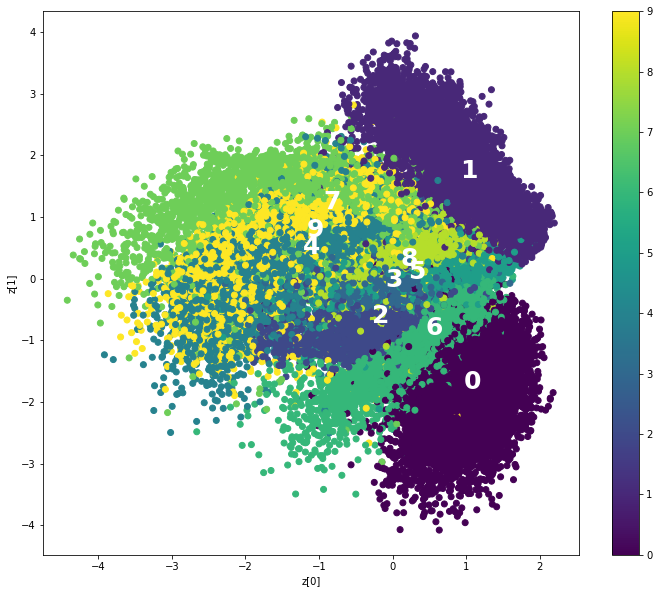

In [13]:
(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255
plot_label_clusters(encoder, x_train, y_train, vae=True)

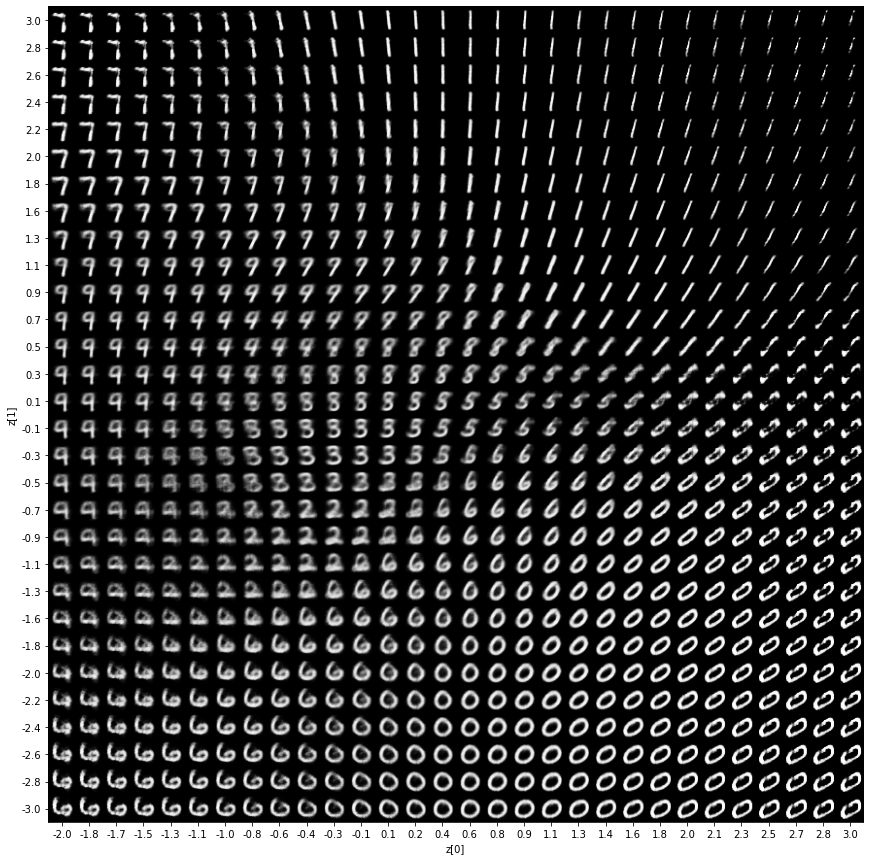

In [14]:
plot_latent_space(decoder, n=30, ranges=[-2, 3, -3, 3], figsize=15)

Copyright 2021 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.